In [8]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import random
import timeit

In [6]:
import numpy as np

In [18]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [23]:
from sklearn.model_selection import train_test_split

In [22]:
import pandas as pd

In [10]:
# !pip list | grep sci

In [33]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 10
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),                  
            nn.Flatten(2))

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x 
        x = self.dropout(x)
        return x
    
model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

torch.Size([512, 50, 16])


In [13]:
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])  # Apply MLP on the CLS token only
        return x

model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape) # BATCH_SIZE X NUM_CLASSES

/Users/justinbarry/opt/anaconda3/envs/vit2/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


torch.Size([512, 10])


In [14]:
# !kaggle competitions download -c digit-recognizer

In [15]:
# !unzip digit-recognizer.zip

In [24]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
submission_df = pd.read_csv("sample_submission.csv")

In [25]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [28]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [29]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "label": label, "index": index}
    
class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "label": label, "index": index}
    
class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indicies):
        self.images = images
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "index": index}

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

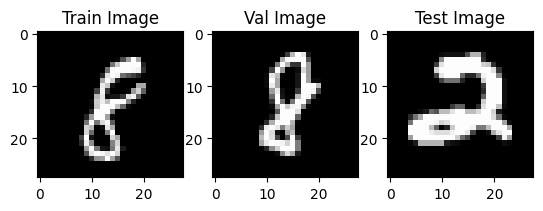

In [30]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Val Image")
print("-"*30)

test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Test Image")
print("-"*30)

plt.show()

In [31]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        loss = criterion(y_pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)         
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

 10%|██████▊                                                             | 1/10 [07:08<1:04:19, 428.79s/it]

------------------------------
Train Loss EPOCH 1: 1.9028
Valid Loss EPOCH 1: 1.6016
Train Accuracy EPOCH 1: 0.3168
Valid Accuracy EPOCH 1: 0.5040
------------------------------


 20%|█████████████▍                                                     | 2/10 [48:50<3:39:44, 1648.09s/it]

------------------------------
Train Loss EPOCH 2: 1.5376
Valid Loss EPOCH 2: 1.3655
Train Accuracy EPOCH 2: 0.5395
Valid Accuracy EPOCH 2: 0.6302
------------------------------


 30%|████████████████████                                               | 3/10 [53:13<1:58:28, 1015.53s/it]

------------------------------
Train Loss EPOCH 3: 1.3552
Valid Loss EPOCH 3: 1.1826
Train Accuracy EPOCH 3: 0.6265
Valid Accuracy EPOCH 3: 0.7269
------------------------------


 40%|███████████████████████████▏                                        | 4/10 [57:58<1:12:44, 727.37s/it]

------------------------------
Train Loss EPOCH 4: 1.2096
Valid Loss EPOCH 4: 1.0904
Train Accuracy EPOCH 4: 0.7006
Valid Accuracy EPOCH 4: 0.7660
------------------------------


 50%|█████████████████████████████████                                 | 5/10 [1:19:59<1:18:27, 941.46s/it]

------------------------------
Train Loss EPOCH 5: 1.1049
Valid Loss EPOCH 5: 0.9695
Train Accuracy EPOCH 5: 0.7409
Valid Accuracy EPOCH 5: 0.7983
------------------------------


100%|████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.45s/it]


------------------------------
Train Loss EPOCH 6: 1.0306
Valid Loss EPOCH 6: 0.9269


 60%|███████████████████████████████████████                          | 6/10 [2:32:12<2:19:37, 2094.50s/it]

Train Accuracy EPOCH 6: 0.7585
Valid Accuracy EPOCH 6: 0.8045
------------------------------


100%|████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.43s/it]


------------------------------
Train Loss EPOCH 7: 0.9592
Valid Loss EPOCH 7: 0.8489


 70%|█████████████████████████████████████████████▌                   | 7/10 [2:43:10<1:21:14, 1624.99s/it]

Train Accuracy EPOCH 7: 0.7782
Valid Accuracy EPOCH 7: 0.8338
------------------------------


100%|████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.45s/it]


------------------------------
Train Loss EPOCH 8: 0.8854
Valid Loss EPOCH 8: 0.8118


 80%|█████████████████████████████████████████████████████▌             | 8/10 [2:53:44<43:39, 1309.50s/it]

Train Accuracy EPOCH 8: 0.8020
Valid Accuracy EPOCH 8: 0.8248
------------------------------


 90%|████████████████████████████████████████████████████████████▎      | 9/10 [3:48:29<32:06, 1926.80s/it]

------------------------------
Train Loss EPOCH 9: 0.8297
Valid Loss EPOCH 9: 0.7363
Train Accuracy EPOCH 9: 0.8147
Valid Accuracy EPOCH 9: 0.8498
------------------------------


100%|██████████████████████████████████████████████████████████████████| 10/10 [4:21:21<00:00, 1941.04s/it]

------------------------------
Train Loss EPOCH 10: 0.7766
Valid Loss EPOCH 10: 0.6642
Train Accuracy EPOCH 10: 0.8270
Valid Accuracy EPOCH 10: 0.8712
------------------------------


100%|██████████████████████████████████████████████████████████████████| 10/10 [4:21:21<00:00, 1568.20s/it]

Training Time: 4477.92s


In [36]:
torch.cuda.empty_cache()

In [37]:
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]])
        
        outputs = model(img)
        
        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|██████████████████████████████████████████████████████████████████████| 55/55 [00:55<00:00,  1.01s/it]


<Figure size 640x480 with 0 Axes>

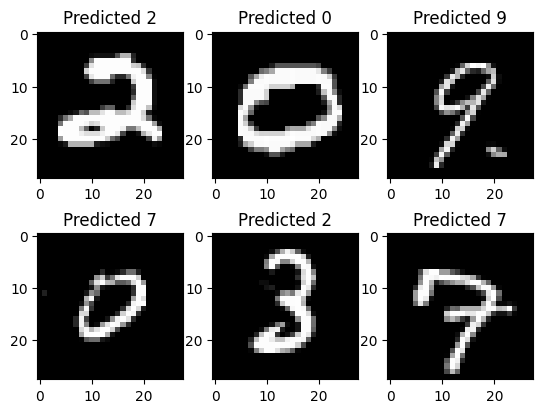

In [38]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1

In [39]:
submission_df = pd.DataFrame(list(zip(ids, labels)),
               columns =["ImageId", "Label"])
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,7
4,5,2
